Available participants:
1. 10_20151125_noon
2. 11_20151024_night
3. 12_20150928_noon
4. 13_20150929_noon
5. 14_20151014_night
6. 15_20151126_night
7. 16_20151128_night
8. 17_20150925_noon
9. 18_20150926_noon
10. 19_20151114_noon
11. 1_20151124_noon_2
12. 20_20151129_night
13. 21_20151016_noon
14. 2_20151106_noon
15. 3_20151024_noon
16. 4_20151105_noon
17. 4_20151107_noon
18. 5_20141108_noon
19. 5_20151012_night
20. 6_20151121_noon
21. 7_20151015_night
22. 8_20151022_noon
23. 9_20151017_night
Loading data for participant: 11_20151024_night
Creating band power heatmap for participant: 11_20151024_night


C:\Users\janis\AppData\Local\Temp\ipykernel_15268\1264994362.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = participant_data.groupby('quantized_perclos')
C:\Users\janis\AppData\Local\Temp\ipykernel_15268\1264994362.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


Heatmap visualization saved to: visualizations\11_20151024_night_band_power_heatmap.png


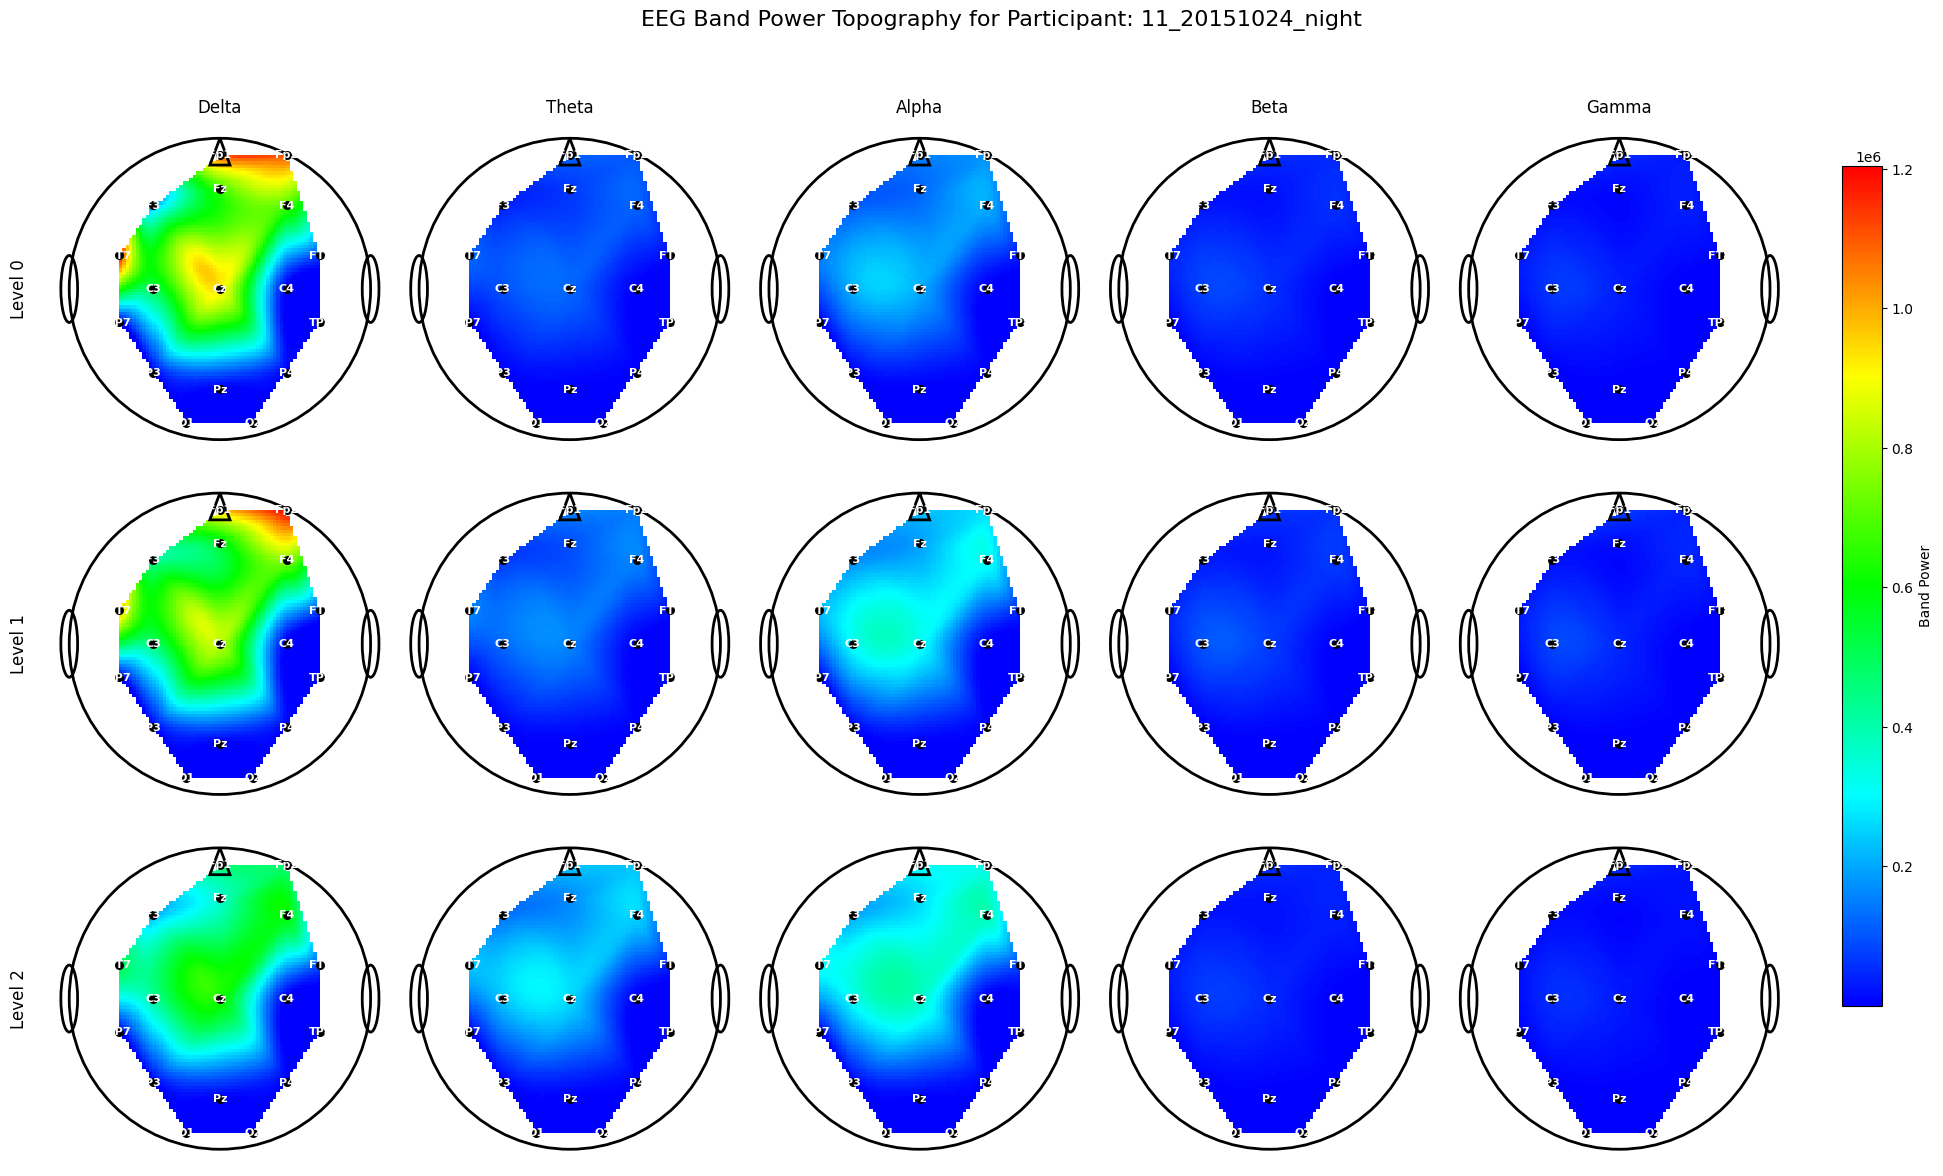

In [ ]:
#TO BE DONE
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from scipy.interpolate import griddata
from utils.data_load import read_participant_names, load_single_user_data

def plot_eeg_band_power_heatmap(participant_data, title=None, save_path=None):
    # Standard 10-20 system electrode positions (normalized coordinates)
    electrode_positions = {
        1: (0.5, 0.9, 'Fp1'),    # Fp1
        2: (0.7, 0.9, 'Fp2'),    # Fp2
        3: (0.3, 0.75, 'F3'),    # F3
        4: (0.5, 0.8, 'Fz'),     # Fz
        5: (0.7, 0.75, 'F4'),    # F4
        6: (0.2, 0.6, 'FT7'),    # FT7
        7: (0.8, 0.6, 'FT8'),    # FT8
        8: (0.3, 0.5, 'C3'),     # C3
        9: (0.5, 0.5, 'Cz'),     # Cz
        10: (0.7, 0.5, 'C4'),    # C4
        11: (0.2, 0.4, 'TP7'),   # TP7
        12: (0.8, 0.4, 'TP8'),   # TP8
        13: (0.3, 0.25, 'P3'),   # P3
        14: (0.5, 0.2, 'Pz'),    # Pz
        15: (0.7, 0.25, 'P4'),   # P4
        16: (0.4, 0.1, 'O1'),    # O1
        17: (0.6, 0.1, 'O2'),    # O2
    }
    
    bands = {
        'delta': 1,  # 0-4 Hz
        'theta': 2,  # 4-8 Hz
        'alpha': 3,  # 8-13 Hz
        'beta': 4,   # 13-30 Hz
        'gamma': 5   # 30+ Hz
    }
    

    colors = [(0, 0, 1), (0, 1, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # Blue -> Cyan -> Green -> Yellow -> Red
    cmap_name = 'brain_activity'
    brain_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
    
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    if title:
        fig.suptitle(title, fontsize=16)
    
    grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
    head_mask = np.sqrt((grid_x - 0.5)**2 + (grid_y - 0.5)**2) <= 0.45
    grouped = participant_data.groupby('quantized_perclos')
    global_min = float('inf')
    global_max = float('-inf')
    
    for level in [0, 1, 2]:
        level_data = grouped.get_group(level) if level in grouped.groups else pd.DataFrame()
        if not level_data.empty:
            for band_name, band_idx in bands.items():
                band_values = []
                for ch in range(1, 18):
                    col_name = f"EEG_5Bands_ch{ch}_feat{band_idx}"
                    if col_name in level_data.columns:
                        band_values.append(level_data[col_name].mean())
                
                if band_values:
                    global_min = min(global_min, min(band_values))
                    global_max = max(global_max, max(band_values))
    
    if global_min == float('inf'):
        global_min = 0
    if global_max == float('-inf'):
        global_max = 1
    
    band_labels = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    
    for level_idx, level in enumerate([0, 1, 2]):
        level_data = grouped.get_group(level) if level in grouped.groups else pd.DataFrame()
        
        if not level_data.empty:
            for band_idx, band_name in enumerate(band_labels):
                ax = axes[level_idx, band_idx]
                
                x_coords = []
                y_coords = []
                values = []
                names = []
                
                band_feature_idx = bands[band_name]
                
                for ch in range(1, 18):
                    col_name = f"EEG_5Bands_ch{ch}_feat{band_feature_idx}"
                    if col_name in level_data.columns:
                        pos = electrode_positions[ch]
                        x_coords.append(pos[0])
                        y_coords.append(pos[1])
                        values.append(level_data[col_name].mean())
                        names.append(pos[2])
                
                if values:
                   
                    grid_z = griddata((x_coords, y_coords), values, (grid_x, grid_y), method='cubic')
             
                    masked_grid_z = np.where(head_mask, grid_z, np.nan)
                    
                
                    im = ax.imshow(
                        masked_grid_z.T,
                        extent=[0, 1, 0, 1],
                        origin='lower',
                        cmap=brain_cmap,
                        vmin=global_min,
                        vmax=global_max
                    )
                    
                    for x, y, name in zip(x_coords, y_coords, names):
                        ax.scatter(x, y, color='black', s=30, zorder=5)
                        ax.text(x, y, name, ha='center', va='center', fontsize=8, color='white', 
                                fontweight='bold', zorder=6)
                
                # Draw head outline
                circle = plt.Circle((0.5, 0.5), 0.45, fill=False, linewidth=2, color='black')
                ax.add_patch(circle)
                
                # Draw nose
                nose = patches.Polygon([(0.5, 0.95), (0.47, 0.87), (0.53, 0.87)], closed=True, fill=False, linewidth=2, color='black')
                ax.add_patch(nose)
                
                # Draw ears
                left_ear = patches.Ellipse((0.05, 0.5), 0.05, 0.2, fill=False, linewidth=2, color='black')
                right_ear = patches.Ellipse((0.95, 0.5), 0.05, 0.2, fill=False, linewidth=2, color='black')
                ax.add_patch(left_ear)
                ax.add_patch(right_ear)
                

                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.set_aspect('equal')
                ax.axis('off')
                
            
                if level_idx == 0:
                    ax.set_title(f"{band_name.capitalize()}")
                if band_idx == 0:
                    ax.text(-0.1, 0.5, f"Level {level}", rotation=90, va="center", ha="center", fontsize=12, transform=ax.transAxes)
    

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Band Power')
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig

def visualize_participant_band_power(participant_name, base_dir="SEED-VIG", output_dir="visualizations"):

    os.makedirs(output_dir, exist_ok=True)

    print(f"Loading data for participant: {participant_name}")
    participant_data = load_single_user_data(participant_name, base_dir)
    
    print(f"Creating band power heatmap for participant: {participant_name}")
    save_path = os.path.join(output_dir, f"{participant_name}_band_power_heatmap.png")
    
    fig = plot_eeg_band_power_heatmap(
        participant_data,
        title=f"EEG Band Power Topography for Participant: {participant_name}",
        save_path=save_path
    )
    
    print(f"Heatmap visualization saved to: {save_path}")
    
    return fig

if __name__ == "__main__":

    base_dir = "SEED-VIG"  
    
    perclos_dir = os.path.join(base_dir, "perclos_labels")
    participant_names = read_participant_names(perclos_dir)["Participant Name"]
    
    print("Available participants:")
    for i, name in enumerate(participant_names):
        print(f"{i+1}. {name}")
    
    chosen_idx = 0  
    try:
        chosen_idx = int(input(f"Choose a participant (1-{len(participant_names)}): ")) - 1
        if chosen_idx < 0 or chosen_idx >= len(participant_names):
            print(f"Invalid choice, using default participant: {participant_names[0]}")
            chosen_idx = 0
    except:
        print(f"Invalid input, using default participant: {participant_names[0]}")
    
    chosen_participant = participant_names[chosen_idx]
    

    visualize_participant_band_power(chosen_participant, base_dir)